# Ensemble & RandomForest

### 1. 투표 기반 분류기

- **동전 시행**

    - 앞면이 51%, 뒷면이 49%가 나오는 조금 균형이 맞지 않는 동전

    - 이 동전을 1,000번 시행하면 앞면 510번, 뒷면 490번

    - 1,000번을 시행한 후 앞면이 다수가 될 확률은 75%

    - (10,000번 던지면 앞면이 다수가 될 확률은 97% 이상)

    - 이는 **"큰 수의 법칙"**

- 이와 비슷하게 (무작위 추측보다 조금 더 나은) 51%의 정확도를 가진 1,000개의 분류기로 앙상블 모델 구축

    - 가장 많은 클래스를 예측으로 삼는다면 75%의 정확도를 기대할 수 있음

    - 하지만 이런 가정은 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 가능

    - 여기서는 같은 데이터로 훈련시키기 때문에 이런 가정이 맞지 않음

    - 분류기들이 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많고 앙상블의 정확도가 낮아짐

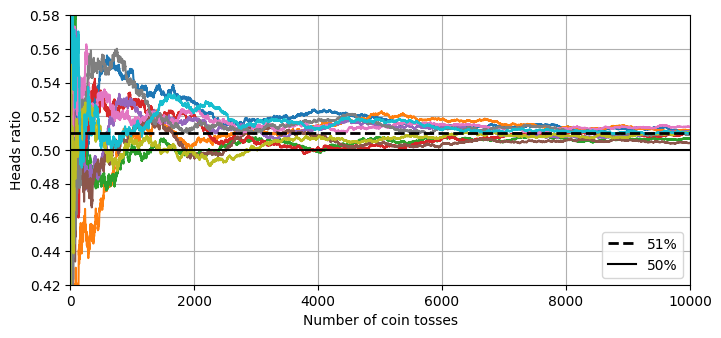

In [8]:
import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
plt.show()

In [9]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, 
                  noise=0.30, 
                  random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(estimators=[
    ('lr', LogisticRegression(random_state=42)), 
    ('rf', RandomForestClassifier(random_state=42)), 
    ('svc', SVC(random_state=42))
])

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [10]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, '=', clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [11]:
voting_clf.predict(X_test[:1])

array([1], dtype=int64)

In [12]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64)]

In [13]:
voting_clf.score(X_test, y_test)

0.912

- 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음을 확인

In [14]:
# soft voting
# 개별 분류기의 예측 확률의 평균을 내어 최종 클래스 예측

voting_clf.voting = 'soft'
voting_clf.named_estimators['svc'].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

### 2. 배깅과 페이스팅

- 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습

- 훈련 세트에서 중복을 허용하여 샘플링하는 방식을 **"배깅"**

- 중복을 허용하지 않고 샘플링 하는 방식을 **"페이스팅"**

- 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있음

- 수집 함수를 통과하면 편향과 분산이 모두 감소

- 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듦

- 또한 예측기는 모두 동시에 다른 CPU 코어나 서버에서 병렬 학습이 가능하기 때문에 인기가 높음


##### 2-1. 사이킷런의 배깅과 페이스팅

In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500,  # 분류기 개수
                            max_samples=100, 
                            n_jobs=-1,  # CPU 코어 개수
                            random_state=42
                            )
# bootstrap = True: 배깅, False로 지정해야 페이스팅

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

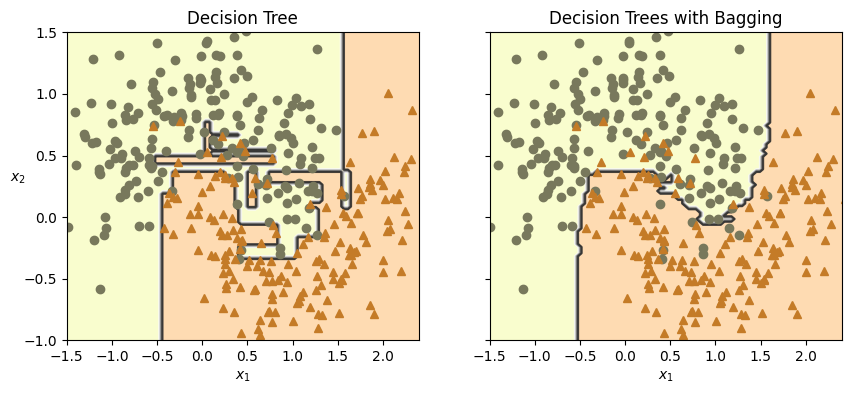

In [16]:
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()

- 일반화가 더 잘 되어 있는 것을 확인

- 앙상블은 비슷한 편향에서 더 작은 분산을 만듦

    - 훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙함

- 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음

- 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 분산을 감소시킴

[분산, 편향]

- **분산**은 모델이 다른 데이터셋에 대해 얼마나 민감한지를 나타냄

- 일반적으로 모델이 너무 복잡하거나 데이터를 과하게 학습할 때 증가

- **편향**은 모델이 실제 관계를 제대로 표현하지 못할 때 나타나는 오차

- 일반적으로 모델이 너무 간단하거나 데이터를 충분히 학습하지 못할 때 증가

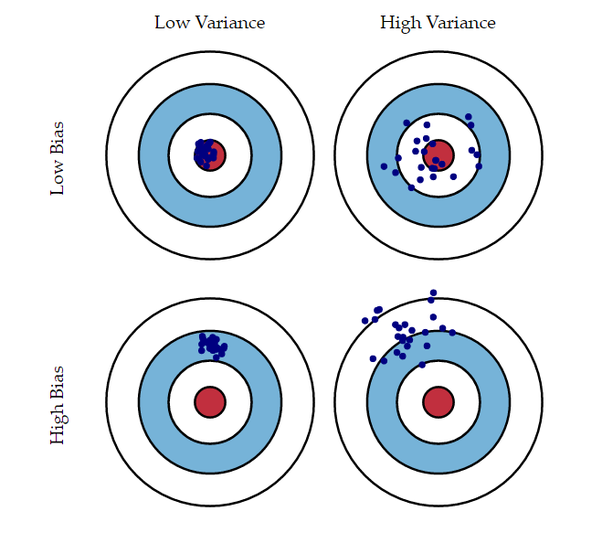

##### 2-2. oob 평가

- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 선택되지 않을 수 있음

- BaggingClassifier는 기본값으로 중복을 허용하여(bootstrap=True) 훈련 세트의 크기만큼인 m개 샘플을 선택

- 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미

- 선택되지 않은 훈련 샘플의 나머지 37%를 oob(out-of-bag) 샘플이라고 부름

- 예측기마다 남겨진 37%는 모두 다름

- 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있음

In [17]:
# m개의 데이터셋에서 하나를 선택하는 확률은 1/m
# 선택되지 않을 확률은 1 - 1/m
# exp(x)는 (1 + x/m)^m, m approaches infinity
# m이 충분히 크다면 exp(-1)과 값이 유사
# exp(-1)은 근삿값 0.37

print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


In [18]:
# oob_score=True로 지정하면 oob 평가를 수행

bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500, 
                            oob_score=True, 
                            n_jobs=-1, 
                            random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [19]:
# probas for the first 3 instances

bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [20]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

### 3. 랜덤 패치와 랜덤 서브스페이스

- BaggingClassifier는 특성 샘플링도 지원

- max_features, bootstrap_features 매개변수에 의해 조절

- 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련

- 이 기법은 이미지와 같은 매우 고차원의 데이터셋을 다룰 때 유용함

- 훈련 특성과 샘플을 모두 샘플링하는 것을 랜덤 패치 방식이라고 함

- 훈련 샘플을 모두 사용하고 (bootstrap=False, max_samples=1.0)

- 특성은 샘플링 (bootstrap_features=True 그리고/또는 max_features=1.0보다 작게 설정) 하는 것을

- **"랜덤 서브스페이스 방식"**

- 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춤

### 4. 랜덤 포레스트

- 배깅 또는 페이스팅을 적용한 결정 트리 앙상블

- 트리의 노드를 분할할 때 전체 특성 중에서 최선을 특성을 찾는 대신

- 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입

- 이는 결국 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 휼륭한 모델을 만들어냄

In [21]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, 
                                 max_leaf_nodes=16, 
                                 n_jobs=-1, 
                                 random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

- RandomForestClassifier와 BaggingClassifier에서 DecisionTreeClassifier를 사용하는 것은 거의 유사하게 만듦

In [22]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16), 
                            n_estimators=500, n_jobs=-1, random_state=42)


In [23]:
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)

True

##### 4-1. 엑스트라 트리

- 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 

- 후보 특성을 사용해 무작위로 분할한 다음 그 중에서 최상의 분할을 선택

- 이와 같이 극단적으로 무작위한 트리의 랜덤 포레스트를 익스트림 랜덤 트리, 엑스트라 트리

- 역시 편향이 늘어나지만 분산을 낮추게 됨

- 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업

- 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름

##### 4-2. 특성 중요도

- 램덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉬움

- 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정

- 더 정확히 말하면 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같음

In [24]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


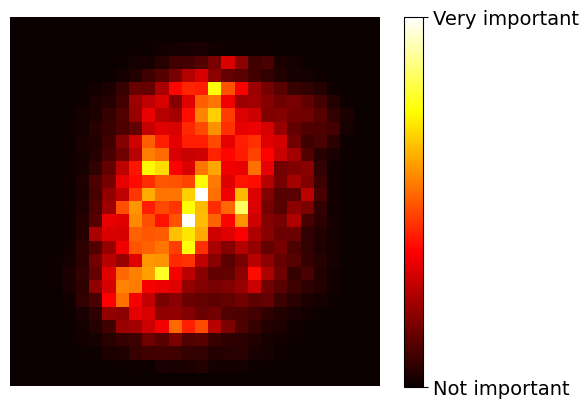

In [19]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False, parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap='hot')
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), 
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis('off')
plt.show()

### 5. 부스팅

- 원래는 가설 부스팅이라고 부름

- 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법

##### 5-1. 에이다부스트

- 이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것

- 이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됨

In [21]:
print(len(X_train))

375


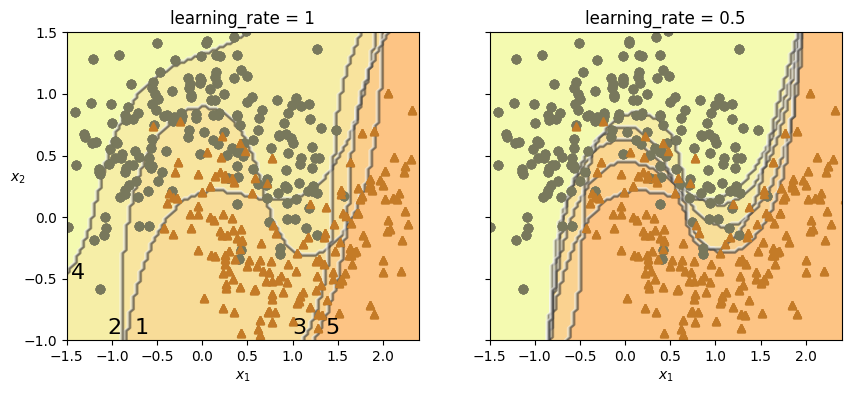

In [18]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

plt.show()

- 예측을 할 때는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치를 더해 결과를 만듦

- 연속된 학습 기법의 중요한 단점은 각 예측기는 이전 예측기가 훈련되고 평가된 후에 학습될 수 있기 때문에 병렬화(또는 분할)을 할 수 없음

- 결국 배깅이나 페이스팅만큼 확장성이 높지 않음

In [22]:
# sklearn은 SAMME라는 에이다부스트의 다중 클래스 버전을 사용
# 클래스가 두 개일 때는 SAMME가 에이다부스트와 동일

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30, 
    learning_rate=0.5, random_state=42
)

ada_clf.fit(X_train, y_train)

c:\Users\magic\anaconda3\envs\HOML\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

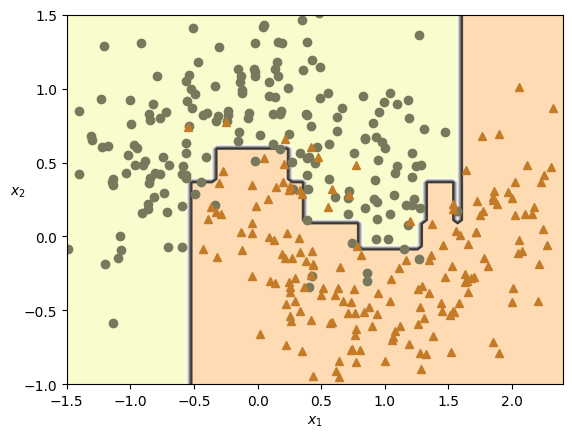

In [23]:
plot_decision_boundary(ada_clf, X_train, y_train)

##### 5-2. 그레이디언트 부스팅

- 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신

- 이전 학습기가 만든 잔여 오차에 새로운 예측기를 학습

In [27]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [28]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [29]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [30]:
X_new = np.array([[-0.4], [0], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

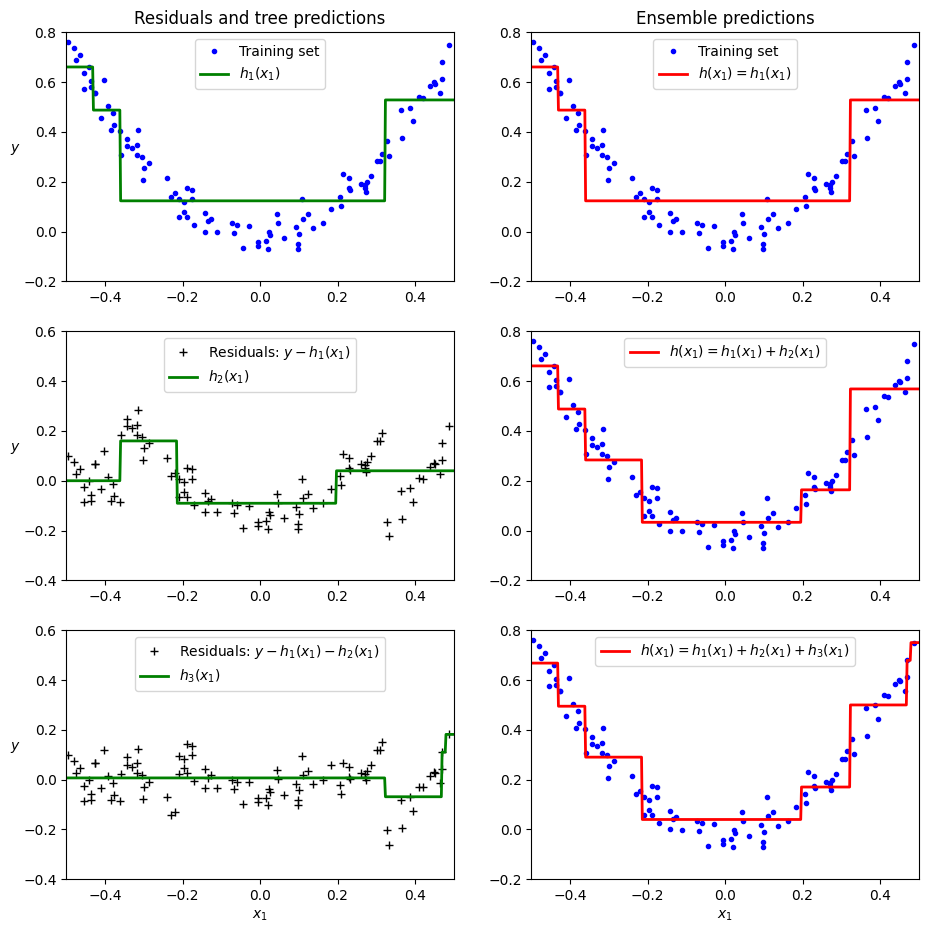

In [31]:
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

plt.show()

In [4]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, 
                                 n_estimators=3, 
                                 learning_rate=1.0, 
                                 random_state=42)

gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [5]:
gbrt_best = GradientBoostingRegressor(max_depth=2, 
                                      learning_rate=0.05, 
                                      n_estimators=500, 
                                      n_iter_no_change=10, # 조기 종료
                                      random_state=42)

gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [6]:
gbrt_best.n_estimators_

92

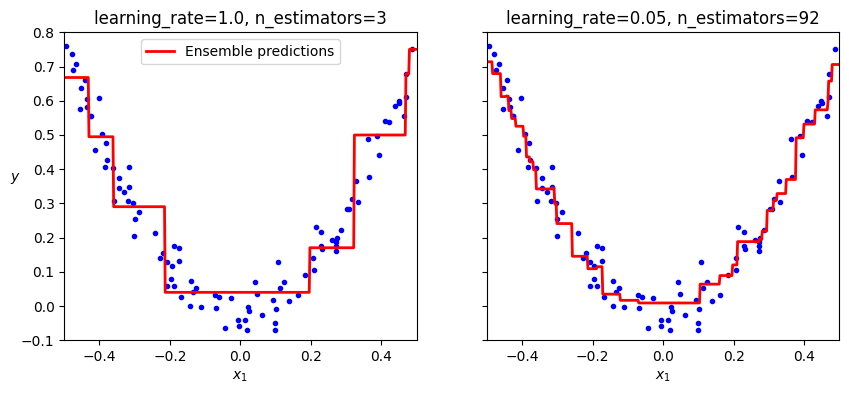

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

plt.show()

- learning_rate 매개변수가 각 트리의 기여 정도를 조절

- learning_rate를 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만

- 일반적으로 예측의 성능은 좋아짐

- **"축소"** 규제 방법

- 최적의 트리 수를 찾기 위해 조기 종료 기법 사용

- GradientBoostingRegressor는 훈련 샘플의 비율 지정 가능

- subsamples=0.25라고 하면 25%의 훈련 샘플로 학습

- 편향이 높아지는 대신(예측값들이 정답과 멀리 떨어짐) 분산이 낮아짐(정답이 모여 있음)

- 또한 훈련 속도를 상당히 높임

- 이런 기법을 **"확률적 그레이디언트 부스팅"**

In [38]:
# 최적화된 그레이디언트 부스팅 구현으로 XGBoost 라이브러리가 유명

import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
print(y_pred[:3])

[0.5308437  0.04761671 0.07259256]


### 6. 스태킹

- 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신

- 취합하는 모델을 훈련시킬 수 없을까?라는 기본 아이디어로 출발

- 블렌더 또는 메타 학습기가 각 예측기가 예측한 값을 최종 예측으로 만듦

- 블렌더를 학습시키는 일반적인 방법은 홀드 아웃 세트를 사용

- 훈련 세트를 두 개의 서브셋으로 나누고 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련

- 첫 번째 레이어의 예측기를 사용해 두 번째(홀드 아웃) 세트에 대한 예측을 만듦

- 이후 블렌더가 첫 번째 레이어가 두 번째 서브셋에 대해 예측한 값을 가지고 타깃값을 예측하도록 학습